In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import glob
from PIL import ImageFile
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
#from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, log_loss, accuracy_score, confusion_matrix 

In [2]:
path_train = '/Users/kelsey/Downloads/PROJECT CODE/ASL_Alphabet_Dataset/asl_alphabet_train'
path_test = '/Users/kelsey/Downloads/PROJECT CODE/test'

In [3]:
train = list(glob.glob(path_train+'/**/*.jpg'))
test = list(glob.glob(path_test+'/*.jpg'))

In [4]:
def process_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [5]:
train_df = process_img(train)

In [6]:
print(f'Number of training pictures: {train_df.shape[0]}')

Number of training pictures: 204924


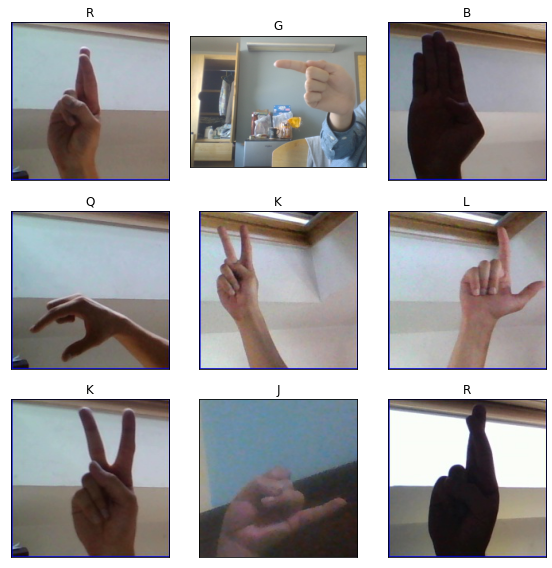

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()


In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_df0, test_df = train_test_split(train_df.sample(frac = 0.05), test_size=0.2, random_state=0)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df0,
    x_col='Filepath',
    y_col='Label',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df0,
    x_col='Filepath',
    y_col='Label',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

Found 6557 validated image filenames belonging to 29 classes.
Found 1639 validated image filenames belonging to 29 classes.
Found 2050 validated image filenames belonging to 29 classes.


2022-04-26 22:59:38.849844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-26 22:59:38.850701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [11]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [12]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(29, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')

    ]

In [15]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks = my_callbacks
)

Epoch 1/50


2022-04-26 22:59:41.008547: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-26 22:59:42.660659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


205/205 [==============================] - ETA: 0s - loss: 1.6033 - accuracy: 0.5597

2022-04-26 23:00:34.793246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


205/205 [==============================] - 66s 305ms/step - loss: 1.6033 - accuracy: 0.5597 - val_loss: 0.8175 - val_accuracy: 0.7608
Epoch 2/50
205/205 [==============================] - 56s 274ms/step - loss: 0.5290 - accuracy: 0.8486 - val_loss: 0.5304 - val_accuracy: 0.8487
Epoch 3/50
205/205 [==============================] - 57s 280ms/step - loss: 0.3098 - accuracy: 0.9160 - val_loss: 0.4112 - val_accuracy: 0.8816
Epoch 4/50
205/205 [==============================] - 55s 269ms/step - loss: 0.1966 - accuracy: 0.9445 - val_loss: 0.3795 - val_accuracy: 0.8877
Epoch 5/50
205/205 [==============================] - 408s 2s/step - loss: 0.1381 - accuracy: 0.9622 - val_loss: 0.3844 - val_accuracy: 0.8865
Epoch 6/50
205/205 [==============================] - 57s 281ms/step - loss: 0.0879 - accuracy: 0.9780 - val_loss: 0.3444 - val_accuracy: 0.8969
Epoch 7/50
205/205 [==============================] - 31s 153ms/step - loss: 0.0655 - accuracy: 0.9847 - val_loss: 0.4331 - val_accuracy: 0.879

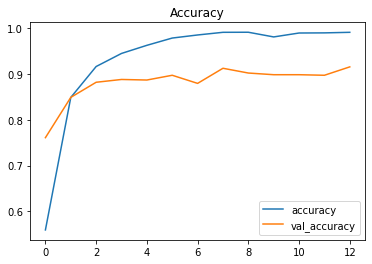

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


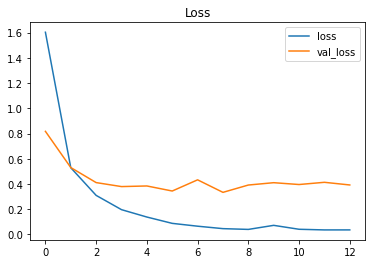

In [17]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [18]:
import pandas as pd
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


loss  accuracy  val_loss  val_accuracy
0   1.603277  0.559707  0.817523      0.760830
1   0.529026  0.848559  0.530414      0.848688
2   0.309759  0.915968  0.411205      0.881635
3   0.196560  0.944487  0.379549      0.887736
4   0.138105  0.962178  0.384445      0.886516
5   0.087925  0.978039  0.344410      0.896888
6   0.065498  0.984749  0.433097      0.879195
7   0.046102  0.990544  0.333781      0.912142
8   0.040017  0.990697  0.391853      0.901769
9   0.072226  0.980479  0.410410      0.898109
10  0.041084  0.989019  0.395909      0.898109
11  0.035987  0.989324  0.413471      0.896888
12  0.036100  0.990544  0.392358      0.915192

In [19]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.34559
Test Accuracy: 92.20%


In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

2022-04-26 23:14:53.570529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The first 5 predictions: ['E', 'L', 'M', 'del', 'O']


In [21]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.96      0.88      0.92        75
           B       0.97      0.94      0.96        70
           C       0.95      0.95      0.95        81
           D       1.00      0.83      0.91        52
           E       0.90      0.95      0.92        63
           F       0.98      0.95      0.97        63
           G       0.86      0.95      0.90        75
           H       0.96      0.95      0.95        77
           I       0.91      0.94      0.92        94
           J       0.92      0.98      0.95        60
           K       0.84      0.97      0.90        74
           L       0.92      0.96      0.94        83
           M       0.98      0.75      0.85        71
           N       0.77      0.99      0.86        73
           O       0.81      0.97      0.88        75
           P       0.95      0.93      0.94        61
           Q       0.92      0.97      0.95        73
           R       0.91    

In [22]:
import seaborn as sns

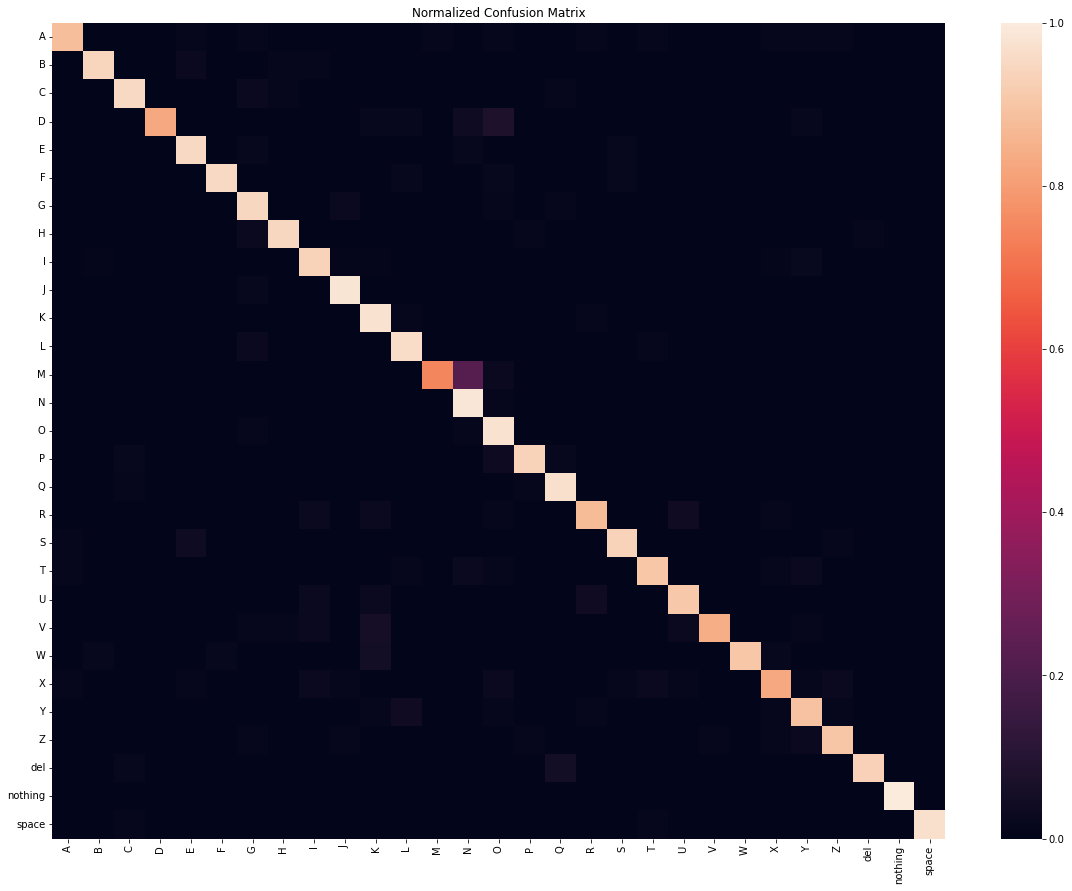

In [23]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

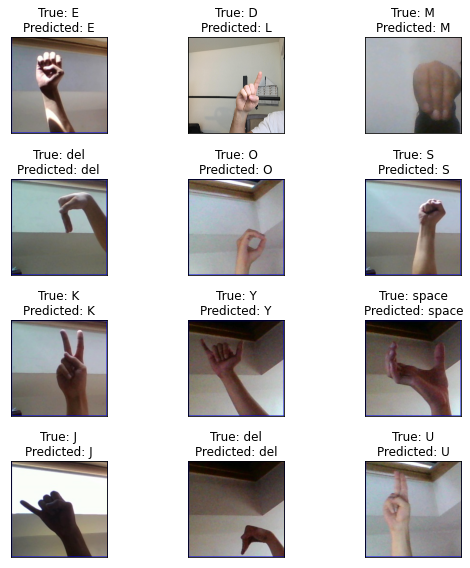

In [24]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [25]:
model.save('./asl_alphabetpredict.h5')

/opt/homebrew/Caskroom/miniforge/base/envs/tflowtwo/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [34]:
model_json = model.to_json()
with open("asl_predict1.json", "w") as json_file:
    json_file.write(model_json)

/opt/homebrew/Caskroom/miniforge/base/envs/tflowtwo/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [36]:
from keras.models import model_from_json
json_file = open('asl_predict1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)